In [6]:
import torch
import numpy as np
import os, sys, glob
import matplotlib.pyplot as plt
import PIL.Image as Image
sys.path.insert(0, "/home/cfoley_waller/defocam/SpectralDefocusCam")
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

import train
import utils.helper_functions as helper
import utils.diffuser_utils as diffuser_utils
import dataset.precomp_dataset as ds

%load_ext autoreload
%autoreload 2

%matplotlib inline

### Define the relevant paths to weights, data and parameters
By defining these paths, the notebook should be able to transition easily between data + model pairings.

In [7]:
use_current_best = False
if use_current_best:
    exp_meas_path = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/10_26/measurements/exp_meas_ducksmallfront_ONAXIS_telecent25um_10_26"
    config_path = "/home/cfoley_waller/defocam/defocuscamdata/models/checkpoint_train_11_16_2023_lri_precomputed_stack3.yml/2023_11_17_21_46_01/training_config.yml"
    trained_weights_path = "/home/cfoley_waller/defocam/defocuscamdata/models/checkpoint_train_11_16_2023_lri_precomputed_stack3.yml/2023_11_17_21_46_01/saved_model_ep297_testloss_0.08411169176300366.pt"
else:
    exp_meas_path = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/exp_meas/duckincar"
    config_path = "/home/cfoley_waller/defocam/defocuscamdata/models/checkpoint_train_11_21_2023_lri_no_adjoint_2d_unet.yml/2024_02_02_21_44_52/training_config.yml"
    trained_weights_path = "/home/cfoley_waller/defocam/defocuscamdata/models/checkpoint_train_11_21_2023_lri_no_adjoint_2d_unet.yml/2024_02_04_10_45_31/saved_model_ep432_testloss_0.06956734766866615.pt"

### Load experimental data
Let's load in our experimental data for inference.

In [8]:
#First we load our config
config = helper.read_config(config_path)
num_ims = config["forward_model_params"]["stack_depth"]
config["device"] = "cuda:1"
device = torch.device(config["device"])
print(torch.cuda.get_device_name(device))
a = torch.tensor([1], device = config['device'])

NVIDIA TITAN Xp


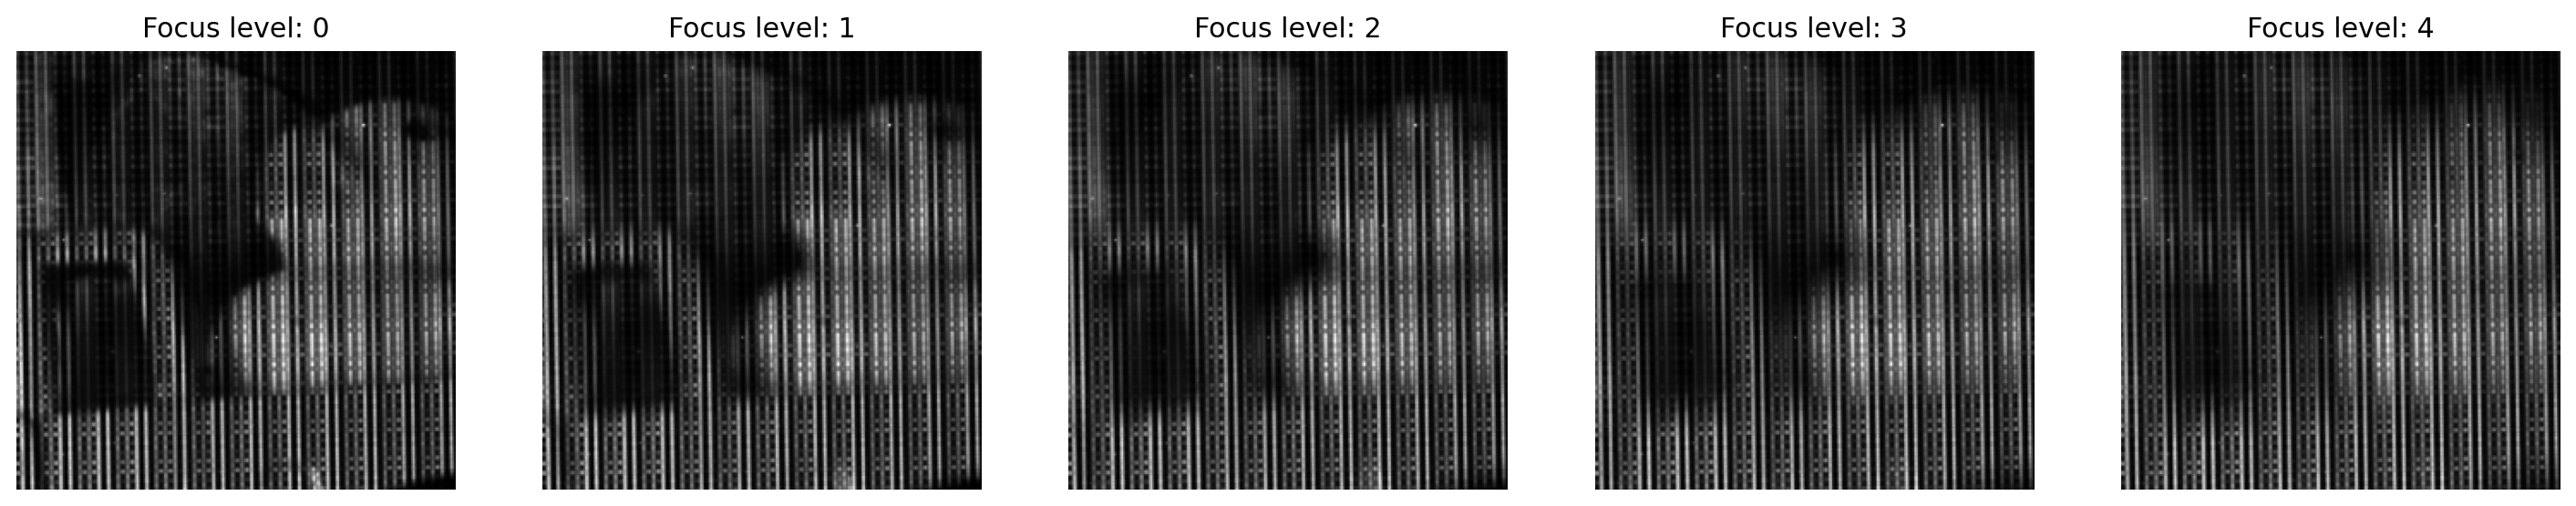

In [9]:
def preprocess_exp_meas(meas, config):
    # read
    center = config["image_center"]
    dim = config["patch_crop"][0]
    crop = lambda x: x[center[0] -dim//2:center[0]+dim//2, center[1]-dim//2: center[1]+dim//2]
    meas =  crop(np.array(Image.open(meas), dtype=float))

    # downsample
    meas = diffuser_utils.pyramid_down(meas, config["patch_size"])

    #one-normalize
    meas = (meas - np.min(meas))/(np.max(meas - np.min(meas)))
    return meas

exp_meas = [preprocess_exp_meas(m, config) for m in sorted(glob.glob(os.path.join(exp_meas_path, "*.bmp")))][:num_ims]

fig, ax = plt.subplots(1, len(exp_meas), figsize = (4*len(exp_meas), 4))
fig.set_dpi(180)
for i,meas in enumerate(exp_meas):
    ax[i].imshow(exp_meas[i], cmap='gray')
    ax[i].set_title(f"Focus level: {i}")
    ax[i].axis('off')
plt.show()

### Build model
First we need to initialize the model and load our weights. We note that the simulation model has performed the adjoint to generate training data, while our experimental data has not, so we need to change some of the model params.

**Note**: This may take a while, as the model needs to load some very large psf calibration data.

In [15]:
config["data_precomputed"] = False #False for exp
config["forward_model_params"]["operations"]["sim_meas"] = False
config["preload_weights"] = True
config["checkpoint_dir"] = trained_weights_path

model = train.get_model(config=config, device=device)
model.eval()
print(f"Model using: {torch.cuda.get_device_name(device)}")


Model using: NVIDIA TITAN Xp


### Run inference
We can now run inference on our data by passing it through the model. It's that simple!

In [16]:
# inference
if config["data_precomputed"]:
    train_loader, val_loader, test_loader = ds.get_data_precomputed(
        config["batch_size"],
        config["data_partition"],
        config["base_data_path"],
        config["num_workers"],
        config["forward_model_params"],
    )
    gt = val_loader.dataset[0]['image'] #NOTE: patch might not be in the val loader
    sim_meas = val_loader.dataset[0]['input']

    fig, ax = plt.subplots(1, len(sim_meas), figsize = (4*len(sim_meas), 4))
    fig.set_dpi(180)
    for i,meas in enumerate(sim_meas.cpu().numpy()):
        ax[i].imshow(np.mean(meas, 0), cmap='gray')
        ax[i].set_title(f"Focus level: {i}")
    plt.show()

    prediction = model(sim_meas.unsqueeze(0).to(device))
else:
    meas_stack = torch.stack([torch.tensor(e, device=device) for e in exp_meas], dim=0)
    meas_stack = torch.unsqueeze(torch.unsqueeze(meas_stack, 1),0)

    meas_stack = torch.roll(meas_stack, 0, 1)

    exp_meas_adj = model.model1(meas_stack)

    #Normalize between models to keep consistency with dataloading
    exp_meas_adj = ((exp_meas_adj - exp_meas_adj.mean()) / exp_meas_adj.std()).float()

    prediction = model.model2(exp_meas_adj)

pred_np = prediction[0].detach().cpu().numpy().transpose(1,2,0)
pred_np = np.round(255 * ((pred_np - np.min(pred_np, axis=2)[...,None]) / np.max(pred_np - np.min(pred_np, axis=2)[...,None])))

### Visualize output

In [17]:
helper.plot_cube_interactive(pred_np, fc_range=[420, 720])

FigureWidget({
    'data': [{'type': 'image',
              'uid': '84730931-5891-455c-b15d-cb74c84670d2',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[  9,   6,   0],
                           [ 17,  12,   2],
                           [ 22,  16,   2],
                           ..., 
                           [  2,   2,   4],
                           [  2,   2,   5],
                           [  3,   2,   4]],
                   
                          [[ 16,  11,   1],
                           [ 26,  19,   1],
                           [ 33,  23,   1],
                           ..., 
                           [  2,   2,   3],
                           [  2,   2,   4],
                           [  2,   2,   3]],
                   
                          [[ 17,  11,   1],
                           [ 27,  19,   1],
                           [ 32,  22,   1],
                           ..., 
                           [  1,   1

In [18]:
helper.plot_cube_interactive(np.transpose(gt.numpy(), (1,2,0)), fc_range=[420, 720])

FigureWidget({
    'data': [{'type': 'image',
              'uid': '138c34b3-4618-4f12-80ea-ade256bdca0e',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[61, 65, 43],
                           [63, 67, 41],
                           [63, 67, 44],
                           ..., 
                           [ 6,  7,  4],
                           [ 6,  7,  4],
                           [ 6,  7,  5]],
                   
                          [[61, 65, 41],
                           [61, 65, 43],
                           [61, 65, 43],
                           ..., 
                           [ 6,  7,  4],
                           [ 6,  7,  4],
                           [ 6,  7,  4]],
                   
                          [[60, 64, 42],
                           [60, 64, 42],
                           [60, 64, 43],
                           ..., 
                           [ 5,  7,  3],
                           [ 5,  6,  4],

In [60]:
# Be warned, this plot can get graphics intensive and/or crash your notebook
helper.plot_cube_3d_scatter(data_cube=pred_np, maxval_thresh=0.4, quantile_thresh=0.7, point_opacity=0.3, point_size=2.5, downsample_yx_scale=3, cscale="Inferno")

In [ ]:
import tqdm as tqdm

def patch_wise_predict(model, mask, meas_stack, device=None):
    """
    Performs patchwise-inference on the measurement stack using the given model. Overlaps
    and adds inferred patches.
    
    The mask must be aligned with the measurement stack.

    Parameters
    ----------
    model : torch.nn.Module
        MyEnsemble model (forward and reverse)
    mask : torch.Tensor
        Mask calibration tensor (channels, y, x)
    meas_stack : torch.Tensor
        Measurement stack (n_blur, y, x)
    """
    model.eval()
    oldmask = model.model1.mask
    device = model.device
    
    mask = mask.to(device)
    meas_stack = meas_stack.to(device)

    chans, tile_y, tile_x = model.model1.mask.shape[-2:]
    image_y, image_x = meas_stack.shape[-2:]
    assert tile_x % 2 == 0, "tile cols must be multiple of 4 pixels"
    assert tile_y % 2 == 0, "tile rows must be multiple of 4 pixels"
    assert tile_x % tile_x == 0, "image cols must be mult of tile cols"
    assert tile_y % tile_y == 0, "image rows must be mult of tile rows"


    output = np.zeros((chans, image_y-tile_y//2, image_x-tile_x//2))
    for i in tqdm.tqdm(range(0, image_y-tile_y, tile_y//2)):
        for j in range(0, image_x-tile_x, tile_x//2):
            in_tile = (i,i+tile_y, j,j+tile_x)
            out_tile = (i+tile_y//4,i+3*tile_y//4, j+tile_x//4,j+3*tile_x//4)

            meas_tile = meas_stack[:, in_tile[0]:in_tile[1],in_tile[2]:in_tile[3]]
            mask_tile = mask[:, in_tile[0]:in_tile[1],in_tile[2]:in_tile[3]]

            model.mask = mask_tile.to(device)
            output_chunk = model(meas_tile.to(device)).cpu().numpy()
            valid_output_chunk = output_chunk[:, tile_y//4:-tile_y//4,tile_x//4:-tile_x//4]
            output[:, out_tile[0]:out_tile[1],out_tile[2]:out_tile[3]] = valid_output_chunk

    model.model1.mask = oldmask
    return output